# VAE bac à sable v2

source : https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [77]:
import torch
import torch.optim as optim
from sklearn.preprocessing import minmax_scale
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import os
from PIL import Image
import pandas as pd
import cv2

In [20]:
# data = pd.DataFrame([cv2.cvtColor(cv2.resize(cv2.imread(f"cat/{path}"), (64, 64)), cv2.COLOR_BGR2GRAY).flatten() for path in os.listdir("cat")])
data = pd.read_csv("chat.csv", header=0, index_col=0)

In [21]:
data

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,211,193,185,183,200,199,200,177,177,199,...,133,155,133,137,118,96,104,120,150,158
1,166,169,178,153,98,102,103,113,125,123,...,99,112,112,101,100,110,127,109,106,108
2,90,18,12,13,14,18,24,21,28,57,...,227,222,221,222,228,228,220,215,211,215
3,32,33,32,33,29,27,21,22,17,14,...,145,135,126,115,148,132,113,116,101,67
4,179,193,186,192,150,163,179,178,162,158,...,104,85,79,52,39,35,31,30,28,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,172,163,145,127,142,167,183,191,187,56,...,36,58,78,100,94,99,43,64,33,57
5649,139,139,140,139,137,135,140,99,59,76,...,87,92,80,84,87,80,71,63,74,77
5650,72,72,73,71,74,74,72,73,71,76,...,204,216,225,200,137,69,36,17,24,28
5651,60,62,63,63,64,70,105,109,75,65,...,133,128,122,119,120,124,125,126,121,125


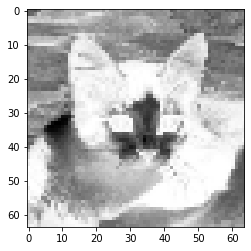

In [4]:
plt.imshow(np.array(data.iloc[1, :]).reshape((64, 64)), cmap="Greys")

In [5]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

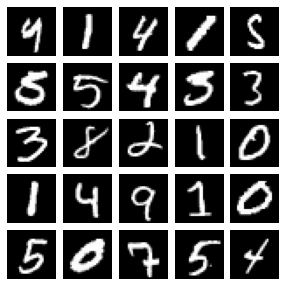

In [7]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [22]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    # def forward(self, x):
    #     mean, logvar = self.encode(x)
    #     z = self.reparameterization(mean, logvar)
    #     x_hat = self.decode(z)
    #     return x_hat, mean, log_var
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [11]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [99]:
def train(model, optimizer, epochs, device, data=train_loader, x_dim=784, expect_label=True):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(data):
            if expect_label:
                x, y = x
            x = x.view(x.size(), x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

# train(model, optimizer, epochs=50, device=device)

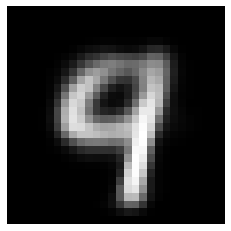

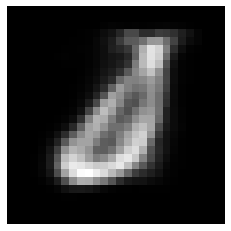

(None, None)

In [15]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

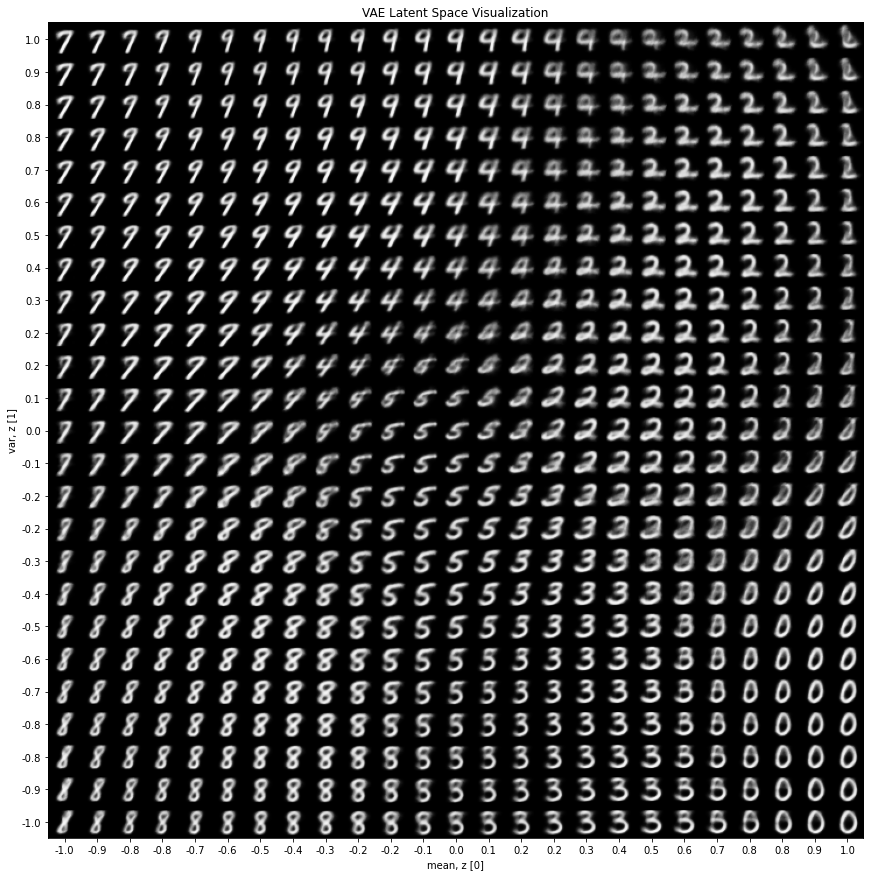

In [16]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

# <span style="color:red">FAUT MTN FAIRES AVECS LES CHATS 

In [17]:
64*64

4096

In [143]:
vae_chat = VAE(64*64, hidden_dim=1500, latent_dim=600)

In [144]:
class CustomDataSet(Dataset):
    def __init__(self, csv_data, transform=None):
        self.df = csv_data
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        line = self.df.iloc[index, :]
        line = torch.tensor(minmax_scale(line), dtype=torch.float32)
        if self.transform:
            line = self.transform(line)
        return line

In [145]:
dataset_cat = CustomDataSet(data)

In [146]:
batch_size = 1000
train_loader_cat = DataLoader(dataset=dataset_cat, batch_size=batch_size, shuffle=True)

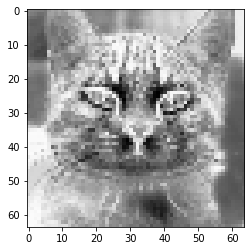

In [147]:
train_loader_cat
X = iter(train_loader_cat)
plt.imshow(next(X)[0].reshape((64, 64)), cmap="Greys")

In [148]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [149]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [150]:
train(vae_chat, optimizer, 20, device, data=train_loader_cat, x_dim=64*64, expect_label=False)

	Epoch 1 	Average Loss:  3218.93325
	Epoch 2 	Average Loss:  3218.76045
	Epoch 3 	Average Loss:  3218.91535
	Epoch 4 	Average Loss:  3218.672925
	Epoch 5 	Average Loss:  3218.795475
	Epoch 6 	Average Loss:  3218.90835
	Epoch 7 	Average Loss:  3218.793075
	Epoch 8 	Average Loss:  3218.79365
	Epoch 9 	Average Loss:  3218.849225
	Epoch 10 	Average Loss:  3218.805025
	Epoch 11 	Average Loss:  3218.97965
	Epoch 12 	Average Loss:  3218.943425
	Epoch 13 	Average Loss:  3218.864825
	Epoch 14 	Average Loss:  3218.89655
	Epoch 15 	Average Loss:  3218.880275
	Epoch 16 	Average Loss:  3218.87455
	Epoch 17 	Average Loss:  3218.85165
	Epoch 18 	Average Loss:  3218.80415
	Epoch 19 	Average Loss:  3218.9482
	Epoch 20 	Average Loss:  3218.86105


16094305.25

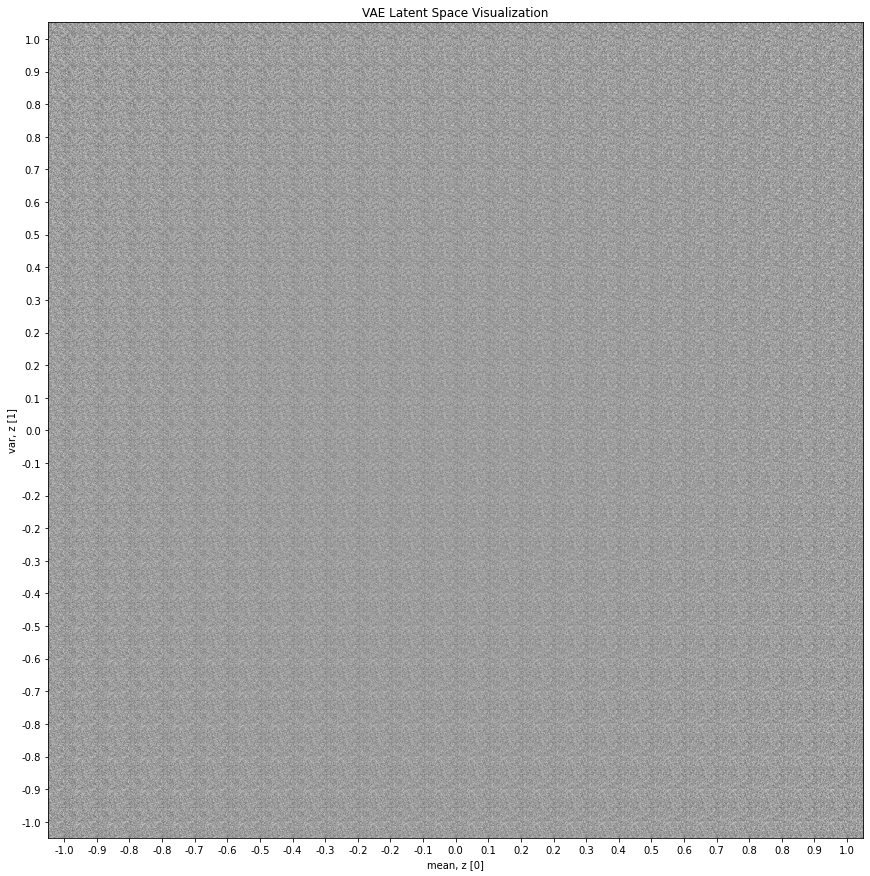

In [151]:
plot_latent_space(vae_chat, digit_size=64)